# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
from helper import set_seed

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
       
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)

        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
   #transforms.GaussianBlur(kernel_size=9),
])

resize_transform = transforms.Compose([
    transforms.Resize((96, 96))
])

# Create the dataset
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\tiff_experiment_unsupervised_data\val&inference\combined_copy"

inference_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\tiff_experiment_unsupervised_data\val&inference\inference"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)

inference_dataset = ImageDataset(image_dir=image_dir, transform=resize_transform)

batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [4]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


In [5]:
for i, (image1, image2, image) in enumerate(val_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


In [6]:
for i, (image1, image2, image) in enumerate(inference_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


Dataset specific normalisation: Normalise using computed mean and std of our special dataset instead of just mean = 0.5,std =0.5

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


mean,std = compute_mean_std(train_loader)
print(mean)
print(std)

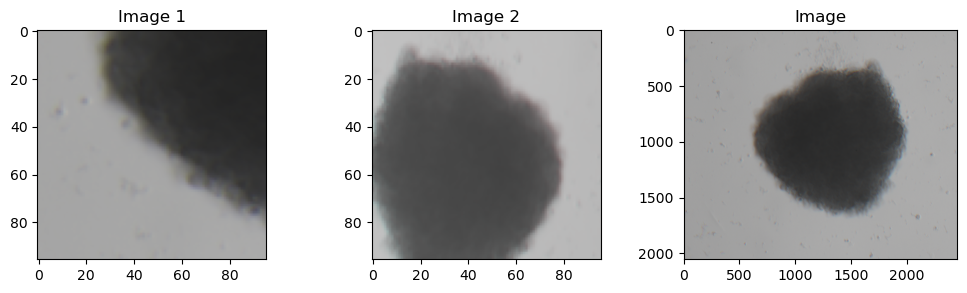

In [10]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first image from the batch
    image1 = image1[0].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[0].numpy().transpose(1, 2, 0)
    image = image[0].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


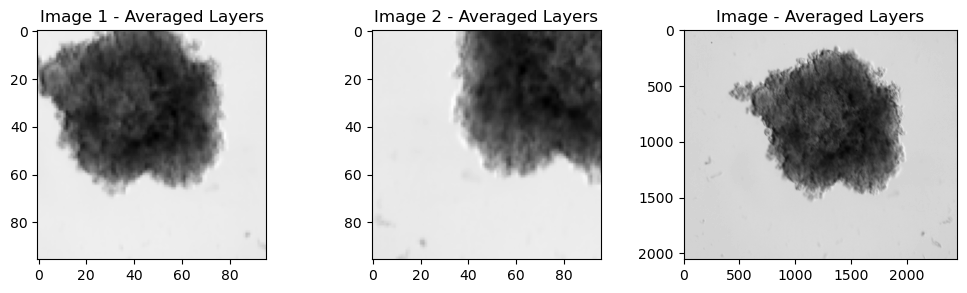

In [11]:
for i, (image1, image2, image) in enumerate(train_loader):
    plt.figure(figsize=(10, 3))
    
    # Average the 3 focal planes (layers) and normalize to range [0, 1]
    image1_avg = image1[0].mean(dim=0)
    image2_avg = image2[0].mean(dim=0)
    image_avg = image[0].mean(dim=0)
    
    # Plot Image1 (average of all layers)
    plt.subplot(1, 3, 1)
    plt.imshow(image1_avg, cmap='gray')
    plt.title('Image 1 - Averaged Layers')
    
    # Plot Image2 (average of all layers)
    plt.subplot(1, 3, 2)
    plt.imshow(image2_avg, cmap='gray')
    plt.title('Image 2 - Averaged Layers')
    
    # Plot Image (average of all layers)
    plt.subplot(1, 3, 3)
    plt.imshow(image_avg, cmap='gray')
    plt.title('Image - Averaged Layers')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch

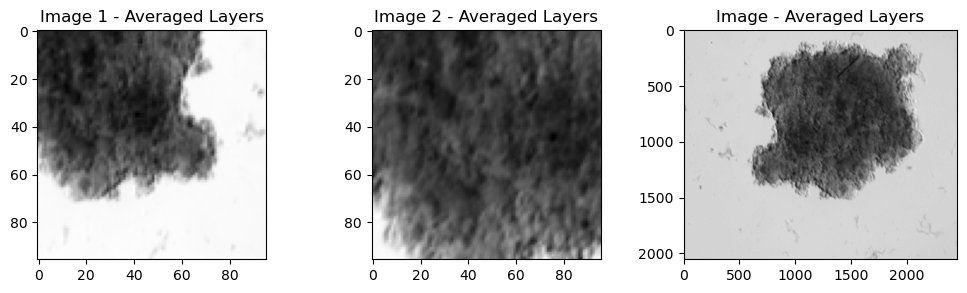

In [12]:
for i, (image1, image2, image) in enumerate(val_loader):
    plt.figure(figsize=(10, 3))
    
    # Average the 3 focal planes (layers) and normalize to range [0, 1]
    image1_avg = image1[0].mean(dim=0)
    image2_avg = image2[0].mean(dim=0)
    image_avg = image[0].mean(dim=0)
    
    # Plot Image1 (average of all layers)
    plt.subplot(1, 3, 1)
    plt.imshow(image1_avg, cmap='gray')
    plt.title('Image 1 - Averaged Layers')
    
    # Plot Image2 (average of all layers)
    plt.subplot(1, 3, 2)
    plt.imshow(image2_avg, cmap='gray')
    plt.title('Image 2 - Averaged Layers')
    
    # Plot Image (average of all layers)
    plt.subplot(1, 3, 3)
    plt.imshow(image_avg, cmap='gray')
    plt.title('Image - Averaged Layers')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch

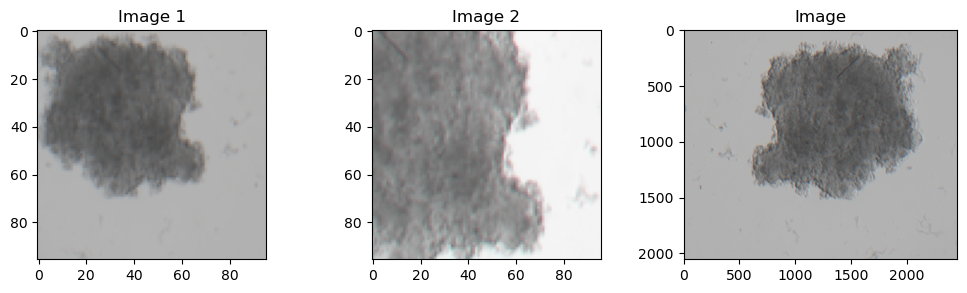

In [15]:

for i, (image1, image2, image) in enumerate(val_loader):
    # Select the first image from the batch
    image1 = image1[0].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[0].numpy().transpose(1, 2, 0)
    image = image[0].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch

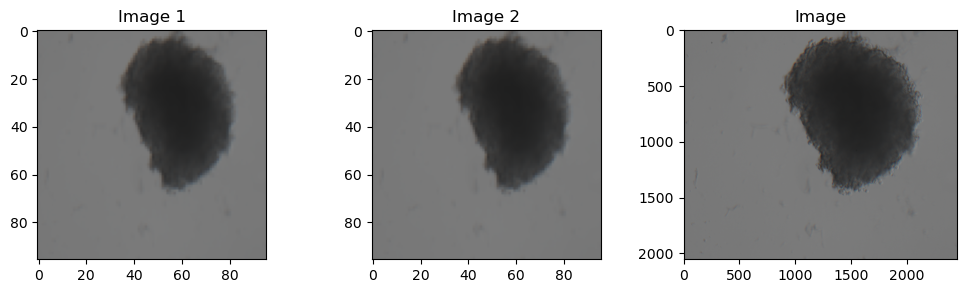

In [14]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(inference_loader):
    # Select the first image from the batch
    image1 = image1[0].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[0].numpy().transpose(1, 2, 0)
    image = image[0].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


In [7]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, inference_losses,
                train_top1_accs, val_top1_accs, inference_top1_accs,
                train_top5_accs, val_top5_accs, inference_top5_accs,
                train_mean_pos, val_mean_pos, inference_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(20, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.plot(epochs, inference_losses, 'go-', label='Inference Loss')
    plt.title('Training, Validation, and Inference Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.plot(epochs, inference_top1_accs, 'go-', label='Inference Top-1 Accuracy')
    plt.title('Training, Validation, and Inference Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.plot(epochs, inference_top5_accs, 'go-', label='Inference Top-5 Accuracy')
    plt.title('Training, Validation, and Inference Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.plot(epochs, inference_mean_pos, 'go-', label='Inference Mean Positive Position')
    plt.title('Training, Validation, and Inference Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses, inference_losses = [], [], []
    train_top1_accs, val_top1_accs, inference_top1_accs = [], [], []
    train_top5_accs, val_top5_accs, inference_top5_accs = [], [], []
    train_mean_pos, val_mean_pos, inference_mean_pos = [], [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train, validate, and infer
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        inference_loss, inference_top1_acc, inference_top5_acc, inference_mean_pos_val = model.inference_epoch(inference_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        inference_losses.append(inference_loss)
        
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        inference_top1_accs.append(inference_top1_acc)
        
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        inference_top5_accs.append(inference_top5_acc)
        
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        inference_mean_pos.append(inference_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Top-1 Acc: {train_top1_acc:.2f}% | Train Top-5 Acc: {train_top5_acc:.2f}% | Train Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Val Top-1 Acc: {val_top1_acc:.2f}% | Val Top-5 Acc: {val_top5_acc:.2f}% | Val Mean Pos: {val_mean_pos_val:.2f} | "
              f"Infer Loss: {inference_loss:.4f} | Infer Top-1 Acc: {inference_top1_acc:.2f}% | Infer Top-5 Acc: {inference_top5_acc:.2f}% | Infer Mean Pos: {inference_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results including inference metrics
    plot_curves(train_losses, val_losses, inference_losses,
                train_top1_accs, val_top1_accs, inference_top1_accs,
                train_top5_accs, val_top5_accs, inference_top5_accs,
                train_mean_pos, val_mean_pos, inference_mean_pos)

    return model


In [ ]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=100)

Using device: cuda


Epoch 1/100 | Train Loss: 3.1774 | Train Top-1 Acc: 0.11% | Train Top-5 Acc: 0.40% | Train Mean Pos: 9.97 | Val Loss: 2.9780 | Val Top-1 Acc: 0.13% | Val Top-5 Acc: 0.38% | Val Mean Pos: 9.66 | Infer Loss: 2.7457 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 54.47 seconds


Training:  11%|█         | 2/18 [00:02<00:19,  1.22s/it]

Inference before projection head

In [5]:
#torch.save(simclr_model.state_dict(), 'model_weights.pth')
full_model_path =  r'C:\Users\k54739\saved_model\simclr_model.pth' 
#torch.save(simclr_model, full_model_path)

In [6]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [7]:
simclr_model = torch.load(full_model_path)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_27424\181344158.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [37]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [9]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [11]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff'

In [12]:
first_image = Preprocess_Image(path_of_image)
print(first_image.shape)
prep_first_image = first_image.unsqueeze(0)
print(prep_first_image.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


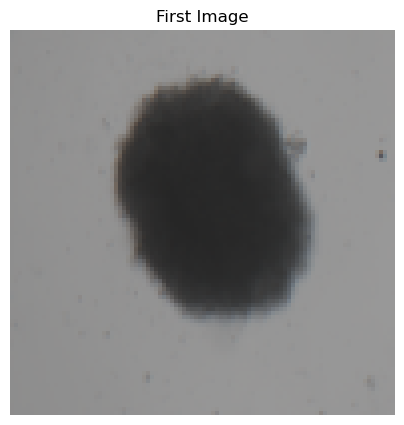

In [13]:
first_image_np = first_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(first_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [14]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff'
second_image = Preprocess_Image(pathimage)
print(second_image.shape)
prep_second_image = second_image.unsqueeze(0)
print(prep_second_image.shape)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


In [15]:
second_image.shape

torch.Size([3, 96, 96])

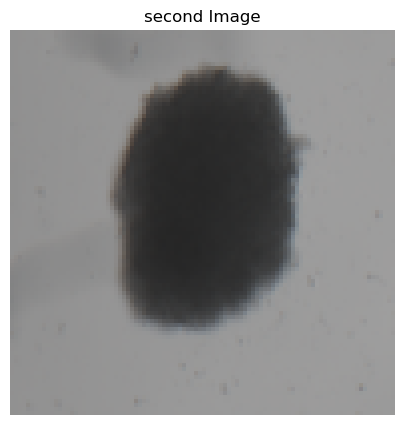

In [16]:
second_image_np = second_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(second_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [17]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [18]:
print(f"simclr_model: {simclr_model}")

simclr_model: SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [19]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, prep_first_image)
second_image_feats = extract_features(simclr_model, prep_second_image)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [20]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.8204046487808228


In [21]:
im_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff'
untreated_image = Preprocess_Image(im_path)
print(untreated_image.shape)
prep_untreated_image = untreated_image.unsqueeze(0)
print(prep_untreated_image.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


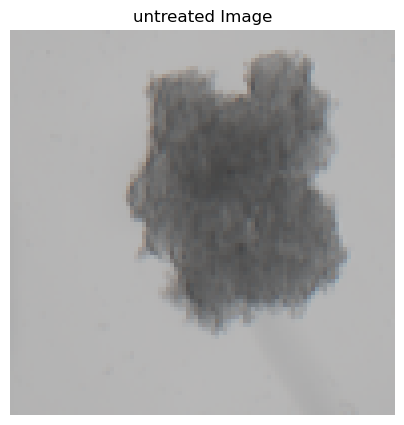

In [22]:
untreated_image_np = untreated_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(untreated_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('untreated Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [23]:
untreated_image_feats = extract_features(simclr_model, prep_untreated_image)

In [24]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.19446787238121033


Inference after projection head

In [25]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [26]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

torch.Size([1, 20])
torch.Size([1, 20])


In [27]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [28]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

torch.Size([1, 20])


In [29]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.18768171966075897


as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [48]:
print(first_image)
first_image.view(-1).shape


tensor([[[0.5470, 0.5567, 0.5606,  ..., 0.5938, 0.5943, 0.5934],
         [0.5529, 0.5582, 0.5605,  ..., 0.5936, 0.5938, 0.5925],
         [0.5568, 0.5596, 0.5608,  ..., 0.5942, 0.5940, 0.5944],
         ...,
         [0.5541, 0.5543, 0.5565,  ..., 0.5892, 0.5886, 0.5892],
         [0.5542, 0.5552, 0.5562,  ..., 0.5879, 0.5885, 0.5889],
         [0.5540, 0.5557, 0.5556,  ..., 0.5879, 0.5893, 0.5899]],

        [[0.5493, 0.5567, 0.5601,  ..., 0.5925, 0.5925, 0.5928],
         [0.5534, 0.5577, 0.5596,  ..., 0.5928, 0.5925, 0.5917],
         [0.5566, 0.5582, 0.5598,  ..., 0.5935, 0.5934, 0.5935],
         ...,
         [0.5527, 0.5535, 0.5554,  ..., 0.5882, 0.5880, 0.5887],
         [0.5528, 0.5538, 0.5552,  ..., 0.5873, 0.5875, 0.5885],
         [0.5527, 0.5552, 0.5550,  ..., 0.5877, 0.5885, 0.5891]],

        [[0.5513, 0.5575, 0.5597,  ..., 0.5920, 0.5915, 0.5917],
         [0.5549, 0.5581, 0.5595,  ..., 0.5924, 0.5924, 0.5921],
         [0.5574, 0.5582, 0.5601,  ..., 0.5923, 0.5935, 0.

torch.Size([27648])

In [49]:
print(second_image)
second_image.view(-1).shape

tensor([[[0.5667, 0.5681, 0.5692,  ..., 0.6117, 0.6131, 0.6123],
         [0.5668, 0.5676, 0.5689,  ..., 0.6129, 0.6132, 0.6120],
         [0.5672, 0.5673, 0.5695,  ..., 0.6136, 0.6136, 0.6136],
         ...,
         [0.5707, 0.5719, 0.5733,  ..., 0.6065, 0.6071, 0.6066],
         [0.5709, 0.5718, 0.5733,  ..., 0.6054, 0.6066, 0.6055],
         [0.5712, 0.5710, 0.5731,  ..., 0.6048, 0.6062, 0.6054]],

        [[0.5658, 0.5665, 0.5675,  ..., 0.6108, 0.6114, 0.6110],
         [0.5656, 0.5661, 0.5677,  ..., 0.6119, 0.6123, 0.6115],
         [0.5656, 0.5665, 0.5685,  ..., 0.6126, 0.6120, 0.6122],
         ...,
         [0.5698, 0.5702, 0.5724,  ..., 0.6060, 0.6059, 0.6056],
         [0.5689, 0.5699, 0.5719,  ..., 0.6044, 0.6053, 0.6034],
         [0.5692, 0.5697, 0.5727,  ..., 0.6040, 0.6049, 0.6042]],

        [[0.5648, 0.5659, 0.5666,  ..., 0.6107, 0.6111, 0.6106],
         [0.5654, 0.5659, 0.5673,  ..., 0.6115, 0.6118, 0.6110],
         [0.5651, 0.5663, 0.5677,  ..., 0.6125, 0.6118, 0.

torch.Size([27648])

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [55]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

False

In [42]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

tensor([0.9914])

In [44]:
untreated_flat = untreated_image.view(-1)

In [46]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

tensor([0.9834])

In [50]:
first_flat == untreated_flat

tensor([False, False, False,  ..., False, False, False])

orig without resizing

In [60]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9906225204467773


In [61]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9821854829788208


In [62]:
WAS IST DAS?
Mach kein Sinn!

SyntaxError: invalid syntax (2322824841.py, line 2)

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [72]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 3.129988785460241e-12


In [77]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 1.0155029384685969e-13


In [69]:
img1

array([[[34168, 35304, 34600, ..., 39241, 39289, 39033],
        [34168, 35224, 34568, ..., 39225, 38569, 38761],
        [34280, 34984, 35048, ..., 38249, 38249, 39817],
        ...,
        [36792, 35864, 36200, ..., 38009, 36376, 38729],
        [36889, 36504, 36504, ..., 40025, 38297, 38041],
        [36280, 37209, 35656, ..., 37753, 37849, 39897]],

       [[36328, 35848, 34584, ..., 39785, 39609, 38585],
        [35032, 34168, 35944, ..., 39609, 39673, 38201],
        [36392, 35608, 35112, ..., 36953, 39433, 38585],
        ...,
        [35736, 35528, 35240, ..., 39017, 37369, 39017],
        [35144, 35464, 36937, ..., 38697, 38921, 38569],
        [35976, 35752, 35928, ..., 39513, 38921, 37897]],

       [[36680, 35688, 36104, ..., 39977, 39001, 38137],
        [35208, 35848, 35480, ..., 39401, 38681, 37321],
        [35240, 35272, 34856, ..., 37705, 39673, 38265],
        ...,
        [35992, 35560, 34696, ..., 37513, 38393, 38745],
        [35496, 34392, 35272, ..., 37929, 388

In [76]:
img2

array([[[37577, 37369, 36792, ..., 39769, 41050, 39209],
        [37689, 36440, 36873, ..., 39929, 40105, 39881],
        [36728, 37337, 36488, ..., 39097, 40521, 40249],
        ...,
        [37561, 37577, 37449, ..., 38793, 38137, 40297],
        [35784, 38121, 37833, ..., 40025, 39689, 39481],
        [38345, 37065, 38569, ..., 39561, 39497, 39753]],

       [[37321, 37529, 36840, ..., 39881, 39961, 41162],
        [36440, 37049, 37049, ..., 40089, 39321, 40889],
        [36056, 36136, 36376, ..., 38713, 40009, 39321],
        ...,
        [36873, 37625, 38121, ..., 39065, 38425, 39737],
        [36889, 37625, 36328, ..., 39929, 39801, 39033],
        [38233, 37385, 38905, ..., 38953, 38809, 39593]],

       [[36969, 36536, 36536, ..., 41098, 41050, 39577],
        [36680, 36296, 36728, ..., 40073, 40970, 39929],
        [36824, 37353, 37241, ..., 39881, 40249, 40697],
        ...,
        [37449, 37097, 37145, ..., 39177, 38409, 40233],
        [37465, 37993, 37865, ..., 39273, 401

In [75]:
img3

array([[[46155, 46875, 44570, ..., 46283, 45947, 44842],
        [46987, 46747, 45995, ..., 47003, 47467, 46251],
        [45403, 46635, 45915, ..., 45387, 46059, 46059],
        ...,
        [45675, 46555, 44666, ..., 45563, 44538, 47003],
        [46091, 45563, 45851, ..., 47083, 46811, 45435],
        [45131, 45787, 46475, ..., 45995, 45835, 46795]],

       [[46891, 45819, 45979, ..., 46299, 46683, 46507],
        [45371, 45675, 46315, ..., 46427, 45403, 45307],
        [45531, 45307, 45723, ..., 44266, 44858, 45979],
        ...,
        [45707, 45627, 45819, ..., 44538, 44922, 46667],
        [46539, 45611, 45147, ..., 46315, 45755, 45034],
        [45179, 45659, 45851, ..., 46779, 46411, 46011]],

       [[45531, 46171, 45883, ..., 45915, 45579, 46795],
        [46363, 47003, 46331, ..., 46507, 44922, 46507],
        [45531, 45515, 46203, ..., 44554, 45467, 45707],
        ...,
        [45707, 44858, 45451, ..., 45131, 45259, 45691],
        [45787, 47019, 44842, ..., 45819, 453

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.